In [1]:
import os, sys
import pandas as pd
import zipfile as zf
import requests

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
import urllib
import itertools
import pylab as pl
import seaborn as sns

from __future__ import division

% pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/michelleho/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Data download and move to data directory

In [2]:
#Handling for both Mac and Windows systems
try:
    df_2010 = pd.read_csv('Data\\CollegeScorecard_Raw_Data\\MERGED2010_11_PP.csv')
except(IOError):
    df_2010 = pd.read_csv('Data/CollegeScorecard_Raw_Data/MERGED2010_11_PP.csv')
#If data not already downloaded, trigger download:
except: 
    url = 'https://ed-public-download.apps.cloud.gov/downloads/CollegeScorecard_Raw_Data.zip'
    file_name = url.split('/')[-1]
    r = requests.get(url)
    with open(file_name, "wb") as code:
        code.write(r.content)
    zipref = zf.ZipFile(file_name, 'r')
    zipref.extractall('Data')
    zipref.close()
    try:
        df_2010 = pd.read_csv('Data\\CollegeScorecard_Raw_Data\\MERGED2010_11_PP.csv')
    except(IOError):
        df_2010 = pd.read_csv('Data/CollegeScorecard_Raw_Data/MERGED2010_11_PP.csv')

/Users/michelleho/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,6,1461,1561,1729) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_2010.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,CDR3_DENOM,CDR2_DENOM
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,NaN,NaN,NaN,...,NaN,0.000000,1198.0,NaN,NaN,1,0.4771,0.5229,NaN,1515.0
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,NaN,NaN,NaN,...,NaN,0.291016,1536.0,NaN,NaN,1,0.4170,0.5830,NaN,2842.0
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,NaN,NaN,NaN,...,NaN,0.000000,13.0,NaN,NaN,1,0.4649,0.5351,NaN,316.0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,NaN,NaN,NaN,...,NaN,0.336907,653.0,NaN,NaN,1,0.5297,0.4703,NaN,1085.0
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,NaN,NaN,NaN,...,NaN,0.000000,1138.0,NaN,NaN,1,0.4097,0.5903,NaN,2054.0


# What to classify: 

Institution Type by debt and wages?


## Control 

1: Public

2: Private Non-Profit

3: Private For-Profit



## REGION 
0	U.S. Service Schools

1	New England (CT, ME, MA, NH, RI, VT)

2	Mid East (DE, DC, MD, NJ, NY, PA)

3	Great Lakes (IL, IN, MI, OH, WI)

4	Plains (IA, KS, MN, MO, NE, ND, SD)

5	Southeast (AL, AR, FL, GA, KY, LA, MS, NC, SC, TN, VA, WV)

6	Southwest (AZ, NM, OK, TX)

7	Rocky Mountains (CO, ID, MT, UT, WY)

8	Far West (AK, CA, HI, NV, OR, WA)

9	Outlying Areas (AS, FM, GU, MH, MP, PR, PW, VI)


## Limit to 4 year universities: ICLEVEL = 1

## Debt variables: 

Median debt for grads: GRAD_DEBT_MDN

Median debt for those who withdraw: WDRAW_DEBT_MDN

Median debt by monthly payment (10 year plan): GRAD_DEBT_MDN10YR

Median debt by fam income

Low (0-30000): LO_INC_DEBT_MDN

Med (30001-75,000): MD_INC_DEBT_MDN

High (>75,000): HI_INC_DEBT_MDN

## Mean & mean earnings of working graduates 6 years after entry

MN_EARN_WNE_P6

MD_EARN_WNE_P6

## Three year repayment rate: 

COMPL_RPY_3YR_RT_SUPP (students who complete)

NONCOM_RPY_3YR_RT_SUPP (students who didn't)

## Cohort Default Rate (2 & 3 years): 
CDR2

CDR3

## Share of students w/ any loan
LOAN_EVER

In [4]:
df_4yr_2010 = df_2010[df_2010.ICLEVEL == 1]

In [5]:
variables = ['CONTROL',
             'REGION',
             'GRAD_DEBT_MDN',
             'WDRAW_DEBT_MDN',
             'GRAD_DEBT_MDN10YR',
             'MN_EARN_WNE_P7',
             'COMPL_RPY_3YR_RT_SUPP', 
             'NONCOM_RPY_3YR_RT_SUPP']

In [6]:
reduced = df_4yr_2010[variables]

In [7]:
reduced = reduced.convert_objects(convert_numeric = 'coerce')
reduced.dropna(inplace = True)

/Users/michelleho/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [8]:
reduced.shape

(2249, 8)

In [9]:
reduced.shape

(2249, 8)

In [10]:
df_2010.shape

(7414, 1743)

# Predict whether Public, Private Non-Profit or Private For-Profit based on Median Debt, Median Earnings (7 Year Mark), Repayment Rate at 3 Years of Students who completed degrees, Repayment Rate at 3 Years of Students who did not complete degrees

In [11]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    
    # creates shading based on percentage true
    percentage_map = np.zeros((len(classes), len(classes)))
    percentages = cm.diagonal() / np.apply_along_axis(sum, axis = 1, arr = conf_m)
    np.fill_diagonal(percentage_map, percentages)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title, fontsize = 15)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30, fontsize = 12)
    plt.yticks(tick_marks, classes, fontsize = 12)
    np.set_printoptions(suppress=True)
    sns.heatmap(percentage_map, annot = True, fmt = '.2g', cbar = True, xticklabels=labels, yticklabels=labels)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)

In [12]:
reduced.groupby('CONTROL').mean()

,REGION,GRAD_DEBT_MDN,WDRAW_DEBT_MDN,GRAD_DEBT_MDN10YR,MN_EARN_WNE_P7,COMPL_RPY_3YR_RT_SUPP,NONCOM_RPY_3YR_RT_SUPP
CONTROL,,,,,,,
1,4.356792,17273.094108,6593.815057,177.272217,38966.284779,0.812856,0.568931
2,4.035088,20468.720330,7928.806502,210.068643,40101.031992,0.810981,0.602654
3,4.884903,20543.167414,6198.109118,210.832687,37527.204783,0.627704,0.343428


In [13]:
reduced = pd.get_dummies(reduced,columns=['REGION'])

In [14]:
reduced.shape

(2249, 16)

In [15]:
reduced.groupby('CONTROL').mean()

,GRAD_DEBT_MDN,WDRAW_DEBT_MDN,GRAD_DEBT_MDN10YR,MN_EARN_WNE_P7,COMPL_RPY_3YR_RT_SUPP,NONCOM_RPY_3YR_RT_SUPP,REGION_1,REGION_2,REGION_3,REGION_4,REGION_5,REGION_6,REGION_7,REGION_8,REGION_9
CONTROL,,,,,,,,,,,,,,,
1,17273.094108,6593.815057,177.272217,38966.284779,0.812856,0.568931,0.058920,0.176759,0.144026,0.081833,0.296236,0.098200,0.042553,0.096563,0.004910
2,20468.720330,7928.806502,210.068643,40101.031992,0.810981,0.602654,0.101135,0.195046,0.178535,0.107327,0.227038,0.050568,0.014448,0.093911,0.031992
3,20543.167414,6198.109118,210.832687,37527.204783,0.627704,0.343428,0.016442,0.080717,0.146487,0.122571,0.339312,0.106129,0.064275,0.122571,0.001495


In [16]:
# percentages of each type. 1 = Public, 2 = Private Non-Profit, 3 = Private For-Profit
reduced.groupby('CONTROL').GRAD_DEBT_MDN.count() / len(reduced)

CONTROL
1    0.271676
2    0.430858
3    0.297466
Name: GRAD_DEBT_MDN, dtype: float64

In [17]:
X = reduced[reduced.columns[2:]]
Y = reduced[reduced.columns[0]]

In [18]:
labels = ['Public', 'Private, Non-Profit', 'Private, For-Profit'] 

----------SVM Linear----------
Insample misclassified = 49.8886414254%
For training size of 0.2%
946 misclassified data out of 1800 ( 52.56 %)
Insample misclassified = 49.276974416%
For training size of 0.4%
729 misclassified data out of 1350 ( 54.0 %)
Insample misclassified = 48.8510007413%
For training size of 0.6%
495 misclassified data out of 900 ( 55.0 %)
Insample misclassified = 49.0272373541%
For training size of 0.8%
230 misclassified data out of 450 ( 51.11 %)


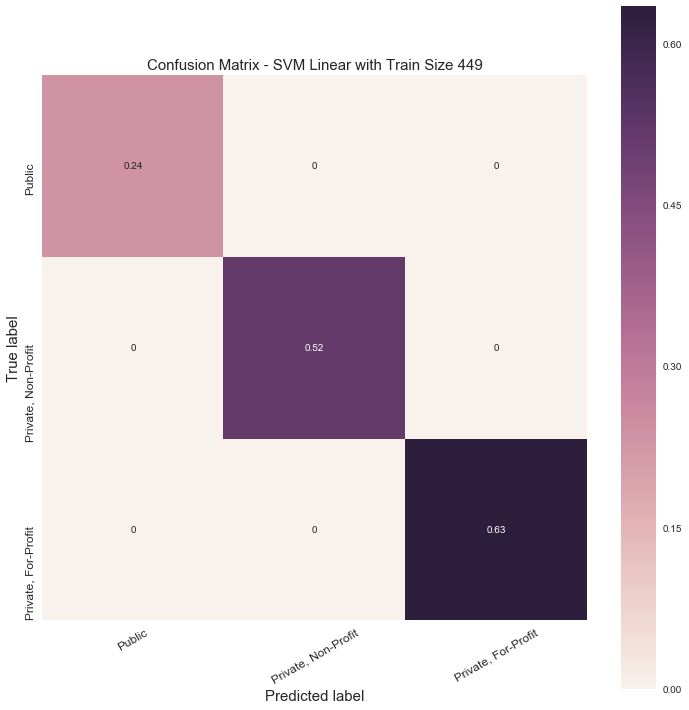

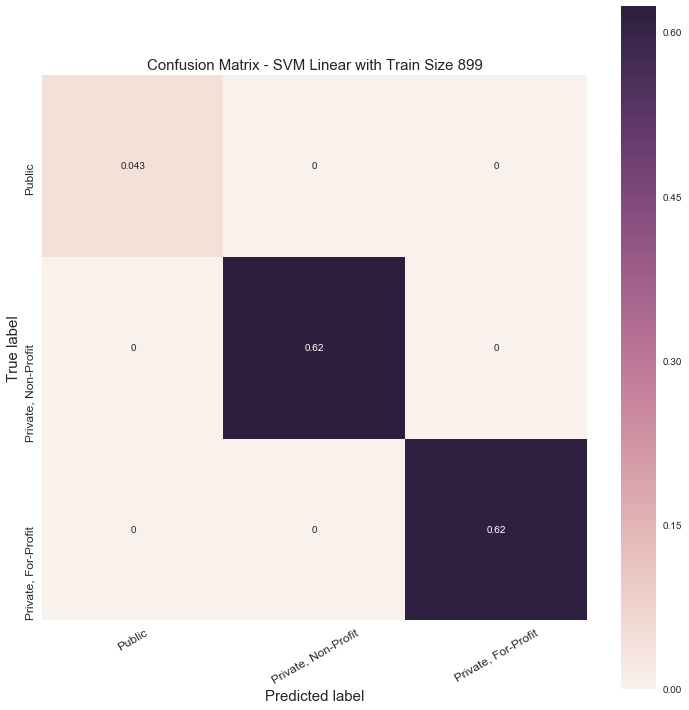

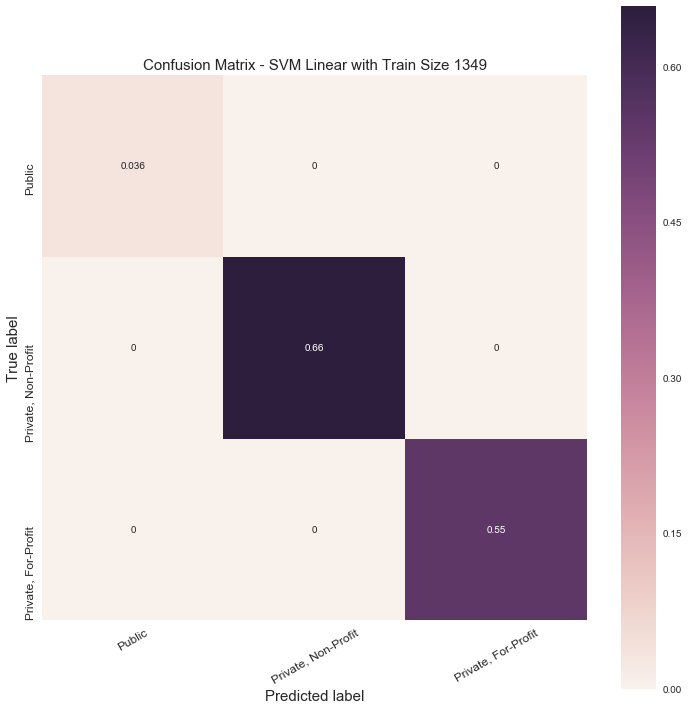

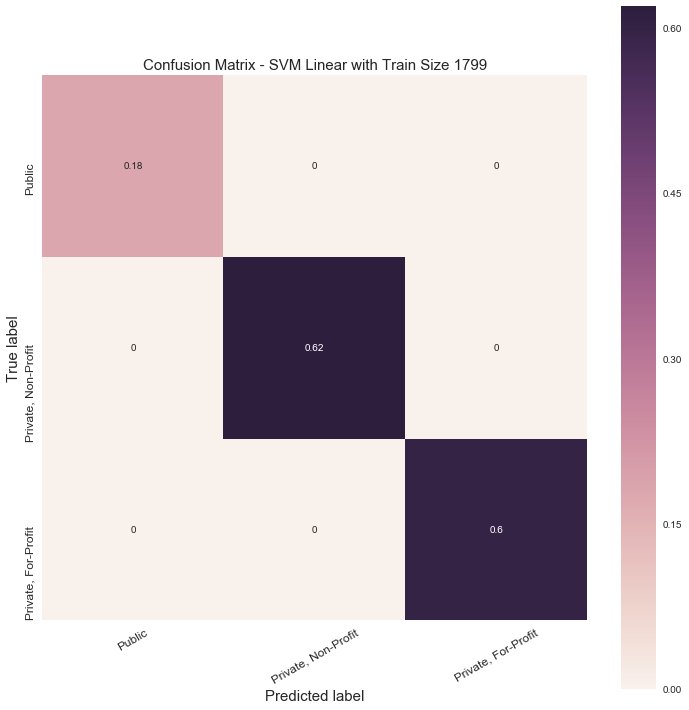

In [19]:
print "----------SVM Linear----------"

for i, n in enumerate([0.8, 0.6, 0.4, 0.2]):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 1 - n, random_state=3)
    ts, = Y_test.shape
    
    svm_linear = svm.SVC(kernel='linear')
    svm_linear.fit(X_train, Y_train)
    ypred_svm_linear = svm_linear.predict(X_test)
    e_svm_linear = sum(ypred_svm_linear != Y_test)
    insample_incorrect = sum(Y_train != svm_linear.predict(X_train)) / Y_train.shape[0] * 100
    print 'Insample misclassified = {0}%'.format(insample_incorrect)

    
    print 'For training size of {0}%'.format(1-n)
    print e_svm_linear, "misclassified data out of", ts, "(", round(e_svm_linear/ts, 4) * 100,"%)"
    
    conf_m = confusion_matrix(Y_test, ypred_svm_linear)
    fig = pl.figure(figsize = (10, 10))
    plot_confusion_matrix(conf_m, classes = labels, 
                          title = 'Confusion Matrix - SVM Linear with Train Size {0}'.format(len(X_train)))
    pl.savefig('confusion_matrix_SVM_Linear_{0}.jpg'.format(str(len(X_train))))

In [21]:
print "----------SVM Linear----------"

for i, n in enumerate([0.8]):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 1 - n, random_state=3)
    ts, = Y_test.shape
    
    svm_linear = svm.SVC(kernel='linear')
    svm_linear.fit(X_train, Y_train)
    ypred_svm_linear = svm_linear.predict(X_test)
    e_svm_linear = sum(ypred_svm_linear != Y_test)
    insample_incorrect = sum(Y_train != svm_linear.predict(X_train)) / Y_train.shape[0] * 100
    print 'Insample misclassified = {0}%'.format(insample_incorrect)

    
    print 'For training size of {0}%'.format(1-n)
    print e_svm_linear, "misclassified data out of", ts, "(", round(e_svm_linear/ts, 4) * 100,"%)"
    
    conf_m = confusion_matrix(Y_test, ypred_svm_linear)
    fig = pl.figure(figsize = (10, 10))
    plot_confusion_matrix(conf_m, classes = labels, 
                          title = 'Confusion Matrix - SVM Linear with Train Size {0}'.format(len(X_train)))
    pl.savefig('confusion_matrix_SVM_Linear_{0}.jpg'.format(str(len(X_train))))

----------SVM Linear----------
Insample misclassified = 49.8886414254%
For training size of 0.2%
946 misclassified data out of 1800 ( 52.56 %)


NameError: global name 'percentage_map' is not defined

# SVM - predict school type based on share of students taking loan and median debt for three income brackets

In [19]:
test_variables = ['CONTROL', 'LO_INC_DEBT_MDN', 'HI_INC_DEBT_MDN', 'MD_INC_DEBT_MDN', 'LOAN_EVER']

In [20]:
test2 = df_4yr_2010[test_variables]

In [21]:
test2 = test2.convert_objects(convert_numeric = 'coerce')
test2.dropna(inplace = True)

/Users/michelleho/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [22]:
test2.groupby('CONTROL').mean()

,LO_INC_DEBT_MDN,HI_INC_DEBT_MDN,MD_INC_DEBT_MDN,LOAN_EVER
CONTROL,,,,
1,10418.746586,10019.700303,10857.918058,0.845874
2,13123.678832,13254.053832,14254.295164,0.922188
3,7542.325221,9675.659292,9224.017699,0.896134


In [23]:
# percentages of each type. 1 = Public, 2 = Private Non-Profit, 3 = Private For-Profit
test2.groupby('CONTROL')['LOAN_EVER'].count() / len(test2)

CONTROL
1    0.270859
2    0.450473
3    0.278668
Name: LOAN_EVER, dtype: float64

In [24]:
X = test2[test2.columns[1:]]
Y = test2[test2.columns[0]]

Insample misclassified = 46.5692503177%
For training size of 1574
336 misclassified data out of 675 ( 49.78 %)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

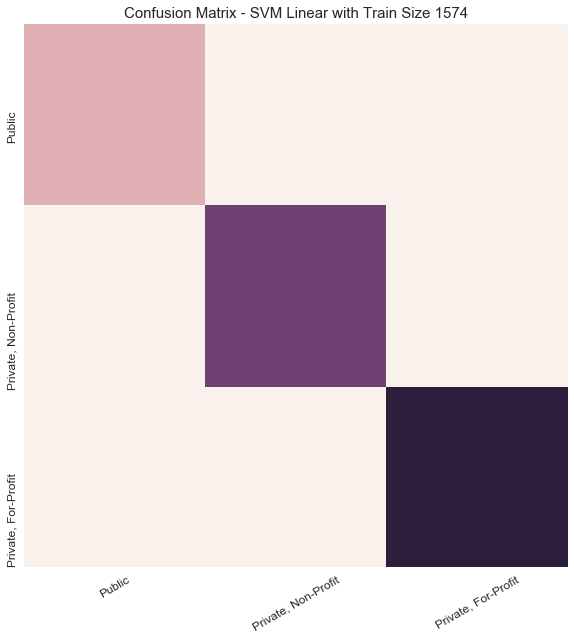

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = .7, random_state=3)
ts, = Y_test.shape

svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(X_train, Y_train)
ypred_svm_linear = svm_linear.predict(X_test)
e_svm_linear = sum(ypred_svm_linear != Y_test)
insample_incorrect = sum(Y_train != svm_linear.predict(X_train)) / Y_train.shape[0] * 100
print 'Insample misclassified = {0}%'.format(insample_incorrect)


print 'For training size of {0}'.format(len(X_train))
print e_svm_linear, "misclassified data out of", ts, "(", round(e_svm_linear/ts, 4) * 100,"%)"

conf_m = confusion_matrix(Y_test, ypred_svm_linear)
fig = pl.figure(figsize = (10, 10))
plot_confusion_matrix(conf_m, classes = labels, 
                      title = 'Confusion Matrix - SVM Linear with Train Size {0}'.format(len(X_train)))
pl.savefig('confusion_matrix_SVM_Linear_{0}.jpg'.format(str(len(X_train))))

In [ ]:
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(X_train, Y_train)
ypred_svm_rbf = svm_rbf.predict(X_test)
e_svm_rbf = sum(ypred_svm_rbf != Y_test)
insample_incorrect = sum(Y_train != svm_rbf.predict(X_train)) / Y_train.shape[0] * 100
print 'Insample misclassified = {0}%'.format(insample_incorrect)


print 'For training size of {0}'.format(len(X_train))
print e_svm_rbf, "misclassified data out of", ts, "(", round(e_svm_rbf/ts, 4) * 100,"%)"

conf_m = confusion_matrix(Y_test, ypred_svm_rbf)
fig = pl.figure(figsize = (10, 10))
plot_confusion_matrix(conf_m, classes = labels, 
                      title = 'Confusion Matrix - SVM Linear with Train Size {0}'.format(len(X_train)))

In [107]:
def classifier(X_train, Y_train, X_test, Y_test, depth, classifier = DecisionTreeClassifier, extra_classifier = None, 
               conf_m = False, **kwargs):
    
    ts = len(X_test)
    
    if extra_classifier == None and classifier == DecisionTreeClassifier:
        
        model = classifier(max_depth = depth)
    
    elif extra_classifier == None and classifier != DecisionTreeClassifier:
        
        model = classifier(max_depth = depth, **kwargs)
        
    else: 
        model = extra_classifier(DecisionTreeClassifier(max_depth = depth), **kwargs)
    
    model.fit(X_train, Y_train)
        
    ypred = model.predict(X_test)

    insample_incorrect_perc = sum(Y_train != model.predict(X_train)) / Y_train.shape[0] * 100
    print 'Insample misclassified = {0}%'.format(round(insample_incorrect_perc, 4))
    in_error = round(insample_incorrect_perc, 4)
    outsample_incorrect = sum(ypred != Y_test)
    outsample_perc_incorrect = outsample_incorrect / ts * 100
    print 'For training size of {0}'.format(len(X_train))
    print '{0} misclassified data out of {1} ({2}%)'.format(outsample_incorrect, ts, round(outsample_perc_incorrect, 4))
   
    
    
    in_error = round(insample_incorrect_perc, 4)
    out_error= round(outsample_perc_incorrect, 4)

    
    return in_error, out_error
    if conf_m == True:
        conf_m = confusion_matrix(Y_test, ypred)
        fig = pl.figure(figsize = (10, 10))
        plot_confusion_matrix(conf_m, classes = labels, 
                              title = 'Confusion Matrix - SVM Linear with Train Size {0}'.format(len(X_train)))

In [45]:
for depth in [5, 10, 15, 20]:
    print '----Results for Depth {0}: Decision Tree Classifier ----'.format(depth)
    classifier(X_train, Y_train, X_test, Y_test, depth)

----Results for Depth 5: Decision Tree Classifier ----
Insample misclassified = 18.9962%
For training size of 1574
181 misclassified data out of 675 (26.8148%)
----Results for Depth 10: Decision Tree Classifier ----
Insample misclassified = 5.7814%
For training size of 1574
161 misclassified data out of 675 (23.8519%)
----Results for Depth 15: Decision Tree Classifier ----
Insample misclassified = 0.953%
For training size of 1574
165 misclassified data out of 675 (24.4444%)
----Results for Depth 20: Decision Tree Classifier ----
Insample misclassified = 0.0%
For training size of 1574
181 misclassified data out of 675 (26.8148%)


In [50]:
in_errors = []
out_errors =[]

for depth in [5, 10, 15, 20]:
    inerror, outerror = classifier(X_train, Y_train, X_test, Y_test, depth)
    in_errors.append(inerror)
    out_errors.append(outerror)

In [71]:
out_errors

[26.6667, 24.0, 25.1852, 24.5926]

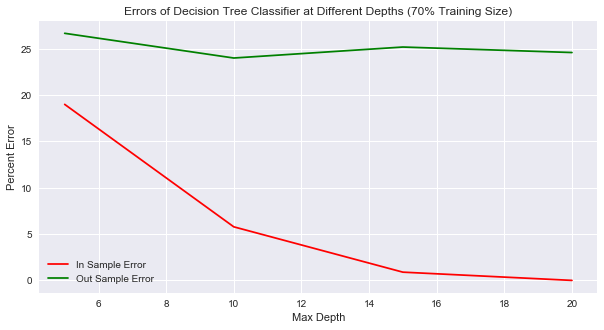

In [78]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,5))
fig = plt.plot([5, 10, 15, 20], in_errors,'-r', [5, 10, 15, 20], out_errors,'g')
plt.legend(['In Sample Error','Out Sample Error'])
plt.xlabel('Max Depth')
plt.ylabel('Percent Error')
plt.title('Errors of Decision Tree Classifier at Different Depths (70% Training Size)')

Insample misclassified = 18.1067%
For training size of 1574
173 misclassified data out of 675 (25.6296%)
Insample misclassified = 17.0267%
For training size of 1574
175 misclassified data out of 675 (25.9259%)
Insample misclassified = 16.3914%
For training size of 1574
166 misclassified data out of 675 (24.5926%)
Insample misclassified = 15.5654%
For training size of 1574
160 misclassified data out of 675 (23.7037%)
Insample misclassified = 17.9797%
For training size of 1574
164 misclassified data out of 675 (24.2963%)
Insample misclassified = 16.582%
For training size of 1574
160 misclassified data out of 675 (23.7037%)
Insample misclassified = 6.2897%
For training size of 1574
160 misclassified data out of 675 (23.7037%)
Insample misclassified = 4.2567%
For training size of 1574
144 misclassified data out of 675 (21.3333%)
Insample misclassified = 4.4473%
For training size of 1574
140 misclassified data out of 675 (20.7407%)
Insample misclassified = 3.6849%
For training size of 1574


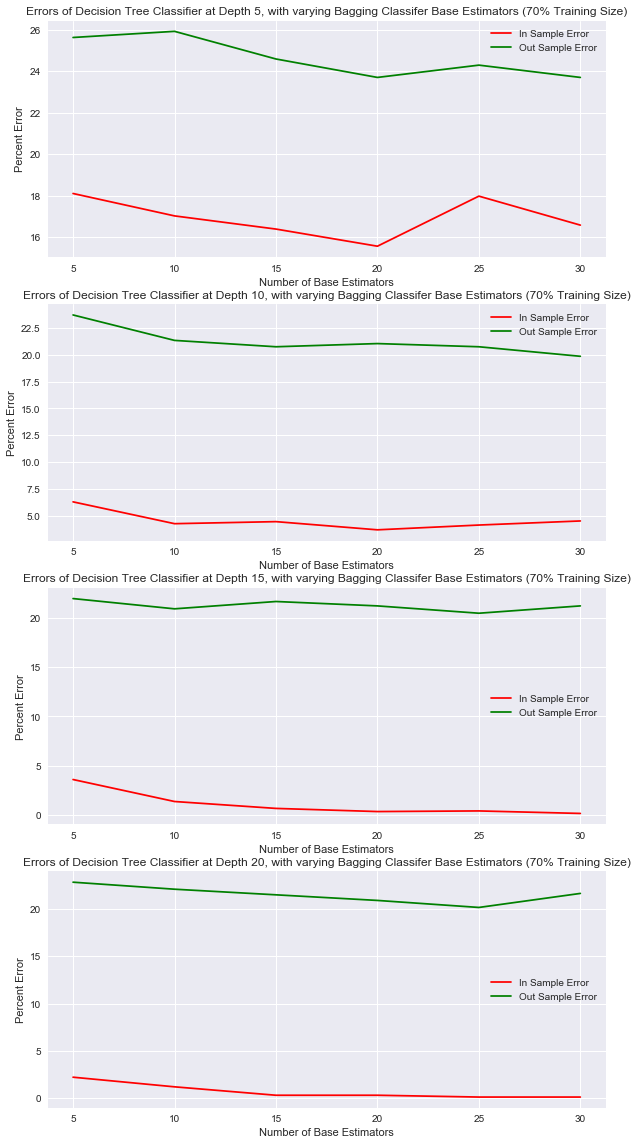

In [114]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,20))
depths = [5, 10, 15, 20]
for i,depth in enumerate(depths):
    in_errors = []
    out_errors = []
    for n in [5, 10, 15, 20, 25, 30]:
#         print '----Results for Depth {0} and {1} Base Estimators: Decision Tree w/Bagging ----'.format(depth, n)
        in_error, out_error = classifier(X_train, Y_train, X_test, Y_test, depth, extra_classifier = BaggingClassifier, 
                   n_estimators = n)
        in_errors.append(in_error)
        out_errors.append(out_error)
    ax = fig.add_subplot("{}1{}".format(len(depths),i+1))

    ax.plot([5, 10, 15, 20, 25, 30], in_errors,'-r', [5, 10, 15, 20, 25, 30], out_errors,'g')
    plt.legend(['In Sample Error','Out Sample Error'])
    plt.xlabel('Number of Base Estimators')
    plt.ylabel('Percent Error')
    plt.title('Errors of Decision Tree Classifier at Depth {}, with varying Bagging Classifer Base Estimators (70% Training Size)'.format(depth,n))

In [ ]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,5))
fig = plt.plot([5, 10, 15, 20], in_errors,'-r', [5, 10, 15, 20], out_errors,'g')
plt.legend(['In Sample Error','Out Sample Error'])
plt.xlabel('Max Depth')
plt.ylabel('Percent Error')
plt.title('Errors of Decision Tree Classifier at Different Depths (70% Training Size)')

----Results for Depth 5 and 5 Base Estimators: Decision Tree w/ADA Boost ----
Insample misclassified = 15.756%
For training size of 1574
202 misclassified data out of 675 (29.9259%)
----Results for Depth 5 and 10 Base Estimators: Decision Tree w/ADA Boost ----
Insample misclassified = 12.77%
For training size of 1574
183 misclassified data out of 675 (27.1111%)
----Results for Depth 5 and 15 Base Estimators: Decision Tree w/ADA Boost ----
Insample misclassified = 11.3723%
For training size of 1574
162 misclassified data out of 675 (24.0%)
----Results for Depth 5 and 20 Base Estimators: Decision Tree w/ADA Boost ----
Insample misclassified = 10.9276%
For training size of 1574
171 misclassified data out of 675 (25.3333%)
----Results for Depth 5 and 25 Base Estimators: Decision Tree w/ADA Boost ----
Insample misclassified = 9.5299%
For training size of 1574
172 misclassified data out of 675 (25.4815%)
----Results for Depth 5 and 30 Base Estimators: Decision Tree w/ADA Boost ----
Insample 

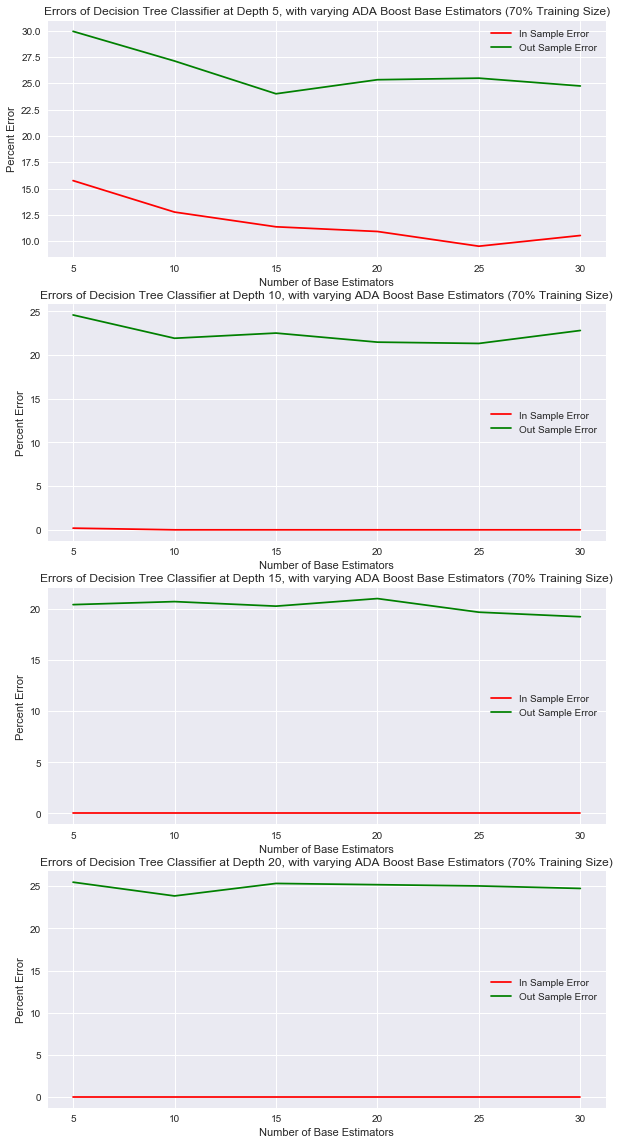

In [115]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,20))
depths = [5, 10, 15, 20]
for i, depth in enumerate(depths):
    in_errors = []
    out_errors = []
    for n in [5, 10, 15, 20, 25, 30]:
        print '----Results for Depth {0} and {1} Base Estimators: Decision Tree w/ADA Boost ----'.format(depth, n)
        in_error, out_error = classifier(X_train, Y_train, X_test, Y_test, depth, extra_classifier = AdaBoostClassifier, n_estimators = n)
        in_errors.append(in_error)
        out_errors.append(out_error)
    ax = fig.add_subplot("{}1{}".format(len(depths),i+1))

    ax.plot([5, 10, 15, 20, 25, 30], in_errors,'-r', [5, 10, 15, 20, 25, 30], out_errors,'g')
    plt.legend(['In Sample Error','Out Sample Error'])
    plt.xlabel('Number of Base Estimators')
    plt.ylabel('Percent Error')
    plt.title('Errors of Decision Tree Classifier at Depth {}, with varying ADA Boost Base Estimators (70% Training Size)'.format(depth,n))

In [153]:
for depth in [5, 10, 15, 20]:
    for n in [5, 10, 15, 20, 25, 30]:
        print '----Results for Depth {0} and {1} Base Estimators: Decision Tree w/ Gradient Boost ----'.format(depth, n)
        classifier(X_train, Y_train, X_test, Y_test, depth, classifier = GradientBoostingClassifier, 
                   n_estimators = n)

----Results for Depth 5 and 5 Base Estimators: Decision Tree w/ Gradient Boost ----
Insample misclassified = 19.9648%
For training size of 1703
175 misclassified data out of 730 (23.9726%)
----Results for Depth 5 and 10 Base Estimators: Decision Tree w/ Gradient Boost ----
Insample misclassified = 18.7317%
For training size of 1703
176 misclassified data out of 730 (24.1096%)
----Results for Depth 5 and 15 Base Estimators: Decision Tree w/ Gradient Boost ----
Insample misclassified = 15.9718%
For training size of 1703
166 misclassified data out of 730 (22.7397%)
----Results for Depth 5 and 20 Base Estimators: Decision Tree w/ Gradient Boost ----
Insample misclassified = 15.2672%
For training size of 1703
162 misclassified data out of 730 (22.1918%)
----Results for Depth 5 and 25 Base Estimators: Decision Tree w/ Gradient Boost ----
Insample misclassified = 14.2689%
For training size of 1703
153 misclassified data out of 730 (20.9589%)
----Results for Depth 5 and 30 Base Estimators: Dec

In [154]:
for depth in [5, 10, 15, 20]:
    for n in [5, 10, 15, 20, 25, 30]:
        print '----Results for Depth {0} and {1} Base Estimators: Random Forest----'.format(depth, n)
        classifier(X_train, Y_train, X_test, Y_test, depth, classifier = RandomForestClassifier, 
                   n_estimators = n)

----Results for Depth 5 and 5 Base Estimators: Random Forest----
Insample misclassified = 20.4345%
For training size of 1703
180 misclassified data out of 730 (24.6575%)
----Results for Depth 5 and 10 Base Estimators: Random Forest----
Insample misclassified = 22.6659%
For training size of 1703
192 misclassified data out of 730 (26.3014%)
----Results for Depth 5 and 15 Base Estimators: Random Forest----
Insample misclassified = 21.374%
For training size of 1703
180 misclassified data out of 730 (24.6575%)
----Results for Depth 5 and 20 Base Estimators: Random Forest----
Insample misclassified = 21.0804%
For training size of 1703
184 misclassified data out of 730 (25.2055%)
----Results for Depth 5 and 25 Base Estimators: Random Forest----
Insample misclassified = 22.1961%
For training size of 1703
199 misclassified data out of 730 (27.2603%)
----Results for Depth 5 and 30 Base Estimators: Random Forest----
Insample misclassified = 21.5502%
For training size of 1703
195 misclassified dat